# Лабораторная работа №5

*Вариант задания:* Товары Jio Mart (вариант - 23)  

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

df = pd.read_csv("..//static//csv//jio_mart_items.csv")
df = df.iloc[:15000]
print(df.columns)

Index(['category', 'sub_category', 'href', 'items', 'price'], dtype='object')


In [2]:
df.head()

category         sub_category  \
0  Groceries  Fruits & Vegetables   
1  Groceries  Fruits & Vegetables   
2  Groceries  Fruits & Vegetables   
3  Groceries  Fruits & Vegetables   
4  Groceries  Fruits & Vegetables   

                                                href  \
0  https://www.jiomart.com/c/groceries/fruits-veg...   
1  https://www.jiomart.com/c/groceries/fruits-veg...   
2  https://www.jiomart.com/c/groceries/fruits-veg...   
3  https://www.jiomart.com/c/groceries/fruits-veg...   
4  https://www.jiomart.com/c/groceries/fruits-veg...   

                                               items  price  
0          Fresh Dates (Pack) (Approx 450 g - 500 g)  109.0  
1  Tender Coconut Cling Wrapped (1 pc) (Approx 90...   49.0  
2                                       Mosambi 1 kg   69.0  
3                               Orange Imported 1 kg  125.0  
4  Banana Robusta 6 pcs (Box) (Approx 800 g - 110...   44.0

In [3]:
df.describe()

price
count  15000.000000
mean     373.427633
std      463.957949
min        5.000000
25%      123.000000
50%      250.000000
75%      446.000000
max    14999.000000

In [4]:
# Процент пропущенных значений признаков
for i in df.columns:
    null_rate = df[i].isnull().sum() / len(df) * 100
    if null_rate > 0:
        print(f'{i} Процент пустых значений: %{null_rate:.2f}')

print(df.isnull().sum())

print(df.isnull().any())

category        0
sub_category    0
href            0
items           0
price           0
dtype: int64
category        False
sub_category    False
href            False
items           False
price           False
dtype: bool


In [5]:
# Проверка типов столбцов
df.dtypes

category         object
sub_category     object
href             object
items            object
price           float64
dtype: object

# Атрибуты  

category: Категория товара.

sub_category: Подкатегория товара.

href: Ссылка на товар.

items: Название товара.

price: Цена товара.

# Цель:
Оптимизация стратегий ценообразования и маркетинга для розничных компаний, стремящихся привлечь покупателей с различными предпочтениями.
Кластеризация товаров на основе их характеристик (категория, подкатегория, цена) для выявления групп с похожими профилями.

## Очистка данных

Цель: Упростить набор данных, удалив несущественные столбцы, чтобы сосредоточиться на ключевых атрибутах, которые будут использоваться для кластеризации и анализа.

Столбцы href и items несущественны для анализа, они не содержат ценной информации для решения задачи.

In [6]:
# Удаление несущественных столбцов
columns_to_drop = ['href', 'items']
df_cleaned = df.drop(columns=columns_to_drop)

print(df_cleaned.head())  # Вывод очищенного DataFrame

    category         sub_category  price
0  Groceries  Fruits & Vegetables  109.0
1  Groceries  Fruits & Vegetables   49.0
2  Groceries  Fruits & Vegetables   69.0
3  Groceries  Fruits & Vegetables  125.0
4  Groceries  Fruits & Vegetables   44.0


## Визуализация парных взаимосвязей
Визуализировать ключевые атрибуты миллиардеров для выявления закономерностей и связей между ними.

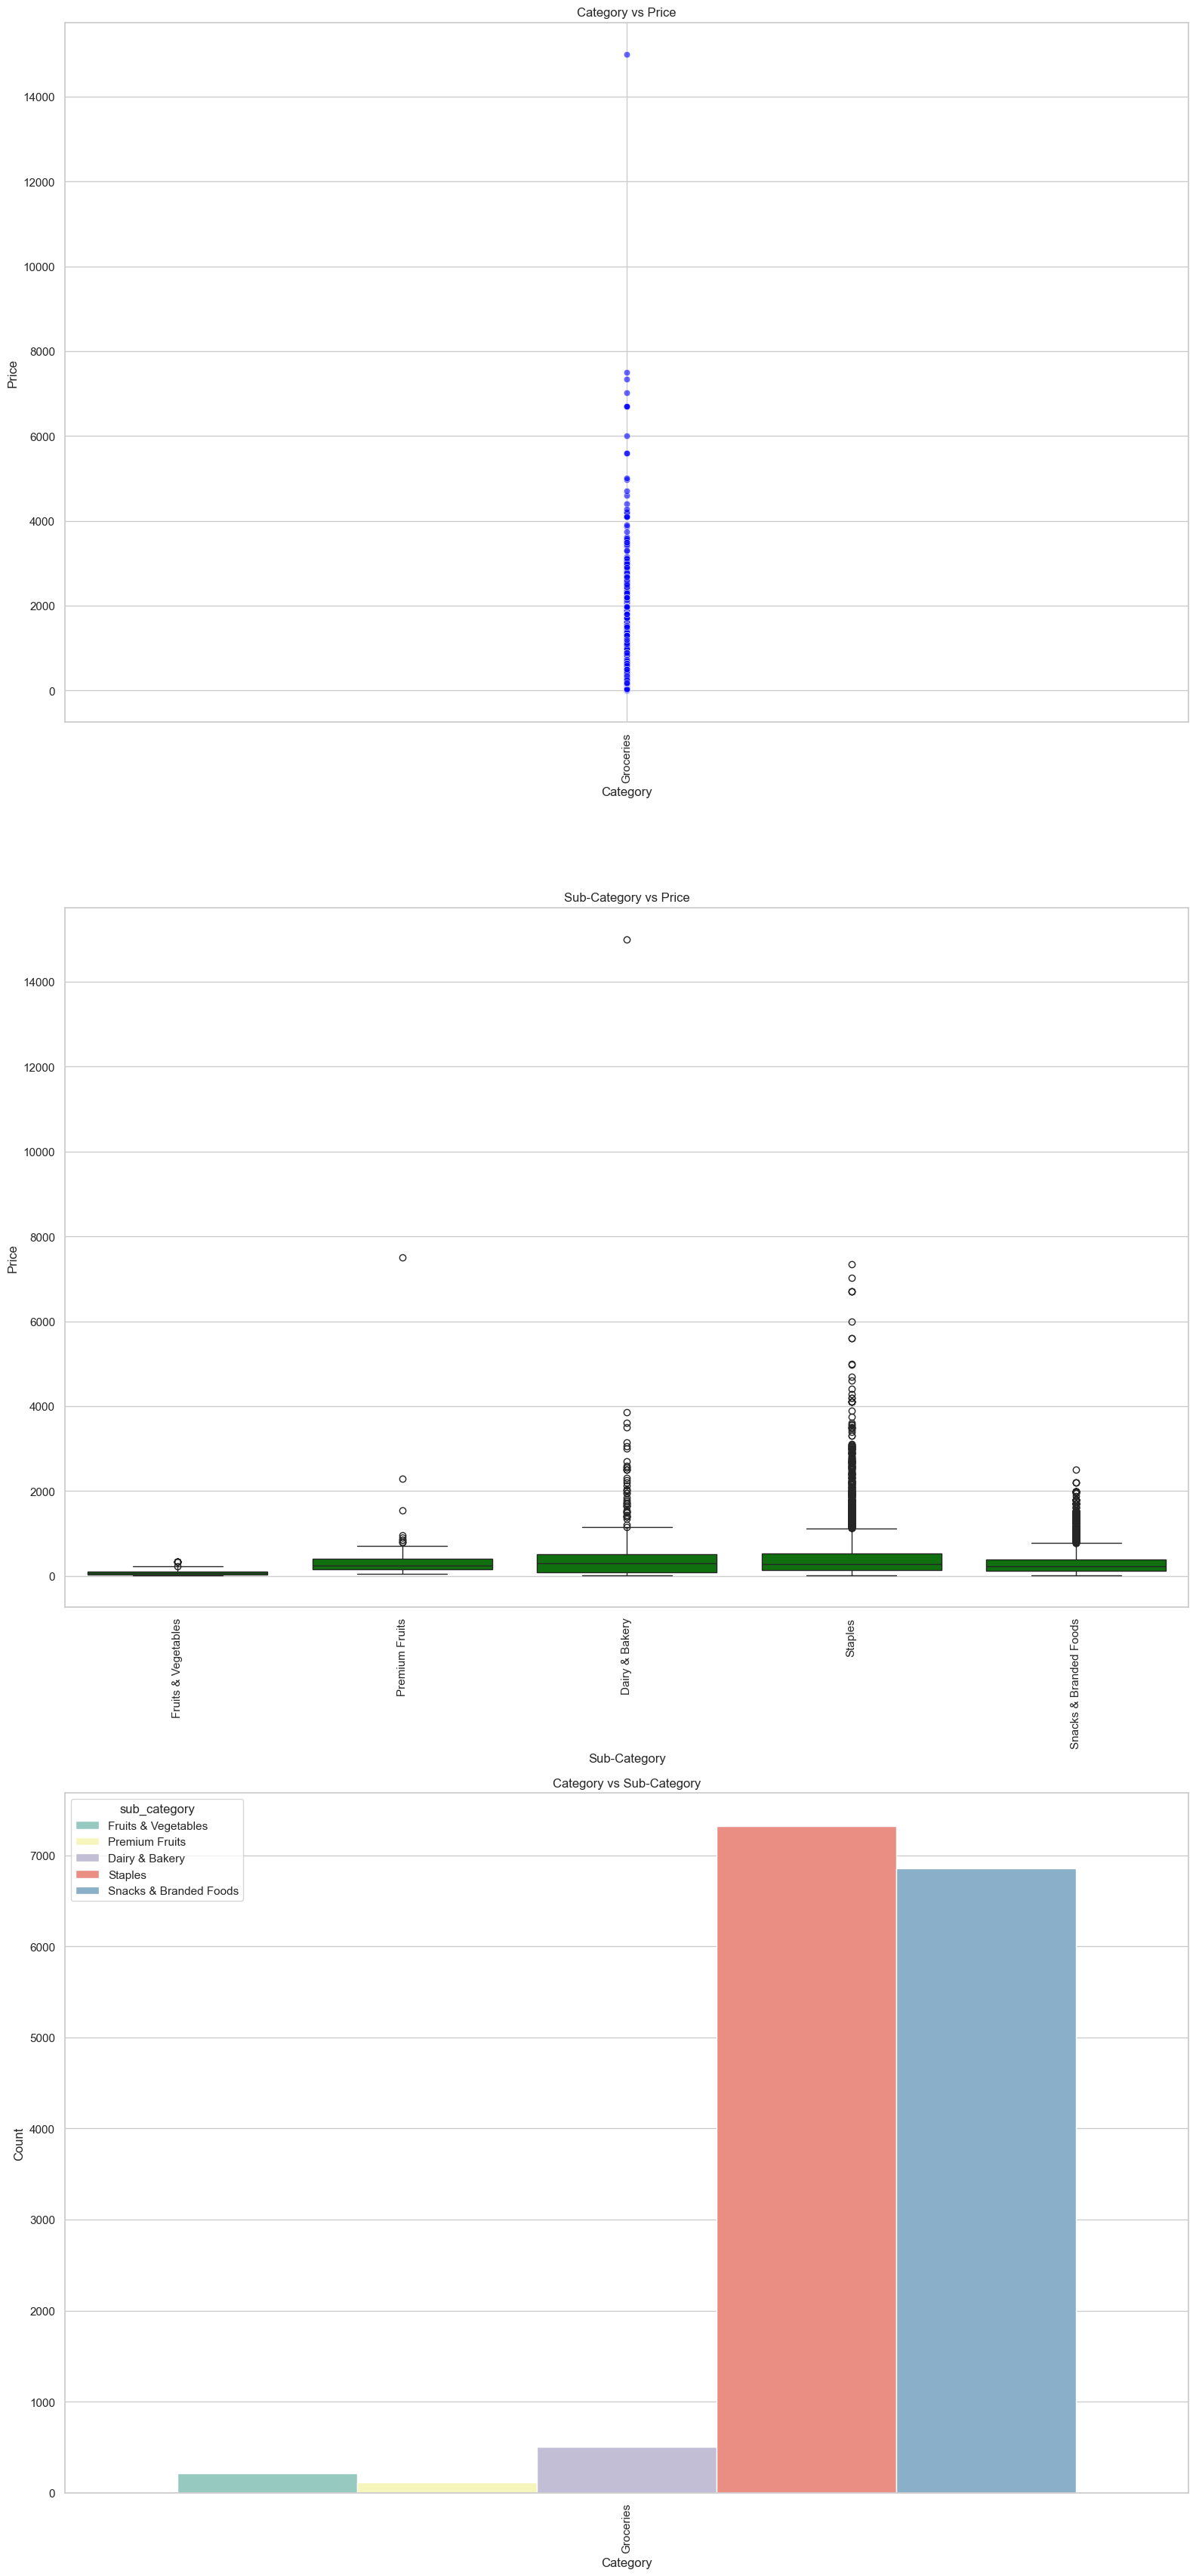

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Настройка стиля графиков
sns.set(style="whitegrid")

# Создание фигуры
plt.figure(figsize=(16, 45))

# График 1: Категория vs Цена
plt.subplot(4, 1, 1)
sns.scatterplot(x=df_cleaned['category'], y=df_cleaned['price'], alpha=0.6, color='blue')
plt.title('Category vs Price')
plt.xlabel('Category')
plt.ylabel('Price')
plt.xticks(rotation=90)

# График 2: Подкатегория vs Цена
plt.subplot(4, 1, 2)
sns.boxplot(x=df_cleaned['sub_category'], y=df_cleaned['price'], color='green')
plt.title('Sub-Category vs Price')
plt.xlabel('Sub-Category')
plt.ylabel('Price')
plt.xticks(rotation=90)

# График 3: Категория vs Подкатегория
plt.subplot(4, 1, 3)
sns.countplot(x=df_cleaned['category'], hue=df_cleaned['sub_category'], palette='Set3')
plt.title('Category vs Sub-Category')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Упорядочиваем графики
plt.tight_layout()
plt.show()

### Стандартизация данных для кластеризации

In [8]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import pandas as pd

# Выделяем числовые и категориальные признаки
numerical_cols = ['price']
categorical_cols = ['category', 'sub_category']

# Масштабирование числовых признаков
scaler = StandardScaler()
df_numerical_scaled = scaler.fit_transform(df_cleaned[numerical_cols])

# Кодирование категориальных признаков с помощью OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)  # sparse=False для удобства
encoded_data = encoder.fit_transform(df_cleaned[categorical_cols])

# Создаем новые столбцы для закодированных категориальных признаков
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_cols))

# Объединяем числовые и закодированные категориальные данные
df_encoded = pd.concat([pd.DataFrame(df_numerical_scaled, columns=numerical_cols), encoded_df], axis=1)

# Выводим результат
print(df_encoded.head())

      price  category_Groceries  sub_category_Dairy & Bakery  \
0 -0.569958                 1.0                          0.0   
1 -0.699284                 1.0                          0.0   
2 -0.656175                 1.0                          0.0   
3 -0.535471                 1.0                          0.0   
4 -0.710061                 1.0                          0.0   

   sub_category_Fruits & Vegetables  sub_category_Premium Fruits  \
0                               1.0                          0.0   
1                               1.0                          0.0   
2                               1.0                          0.0   
3                               1.0                          0.0   
4                               1.0                          0.0   

   sub_category_Snacks & Branded Foods  sub_category_Staples  
0                                  0.0                   0.0  
1                                  0.0                   0.0  
2                

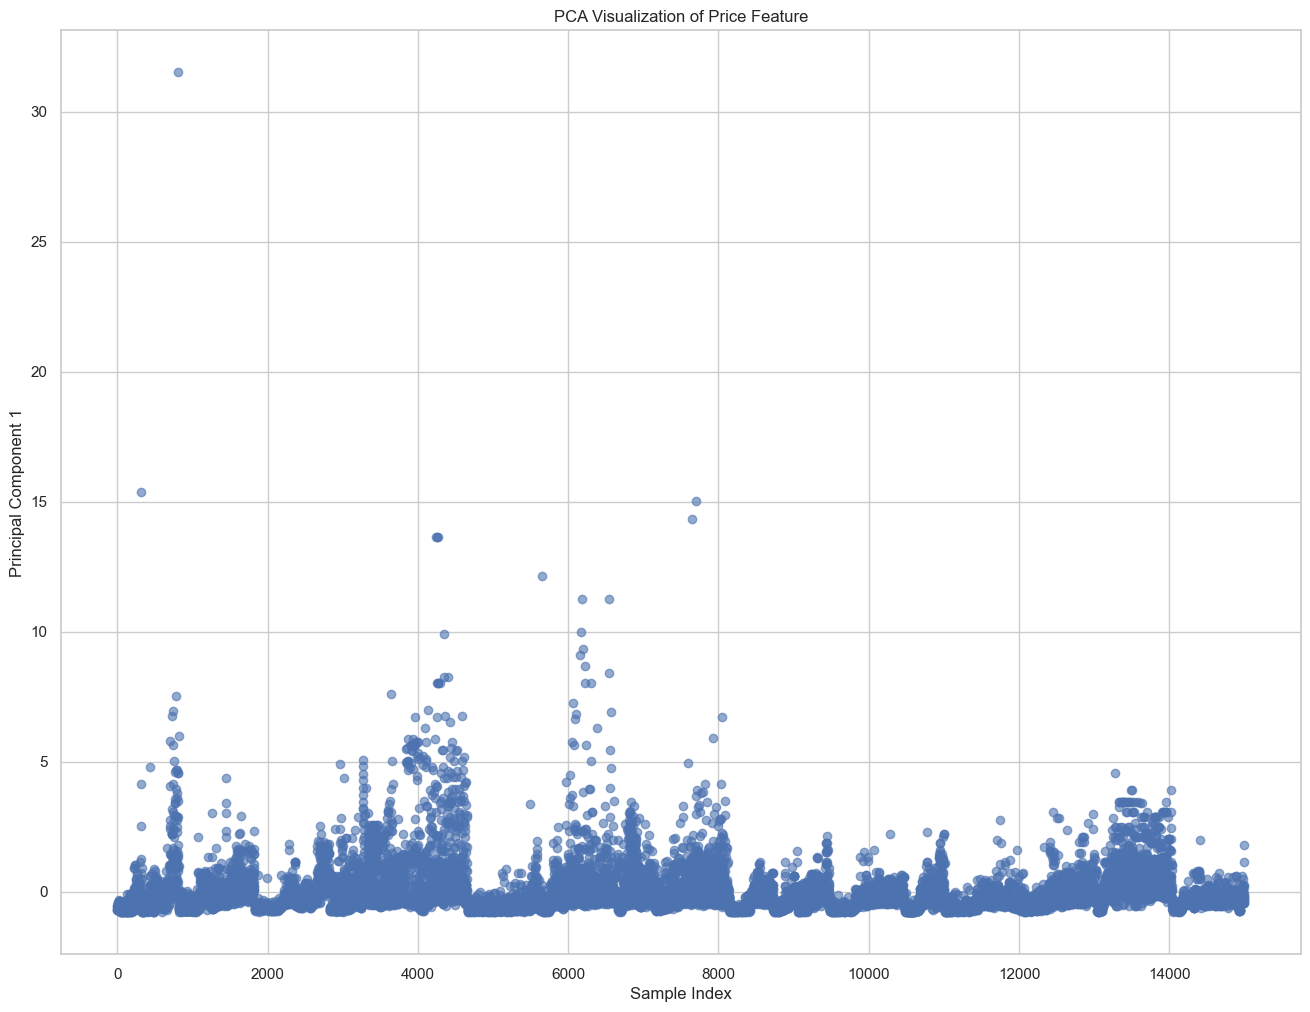

In [9]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Применение PCA ТОЛЬКО к числовым данным
pca = PCA(n_components=1)
kc_pca = pca.fit_transform(df_numerical_scaled)

# Визуализация
plt.figure(figsize=(16, 12))
plt.scatter(range(len(kc_pca)), kc_pca, alpha=0.6)
plt.title("PCA Visualization of Price Feature")
plt.xlabel("Sample Index")
plt.ylabel("Principal Component 1")
plt.show()

### Агломеративная (иерархическая) кластеризация

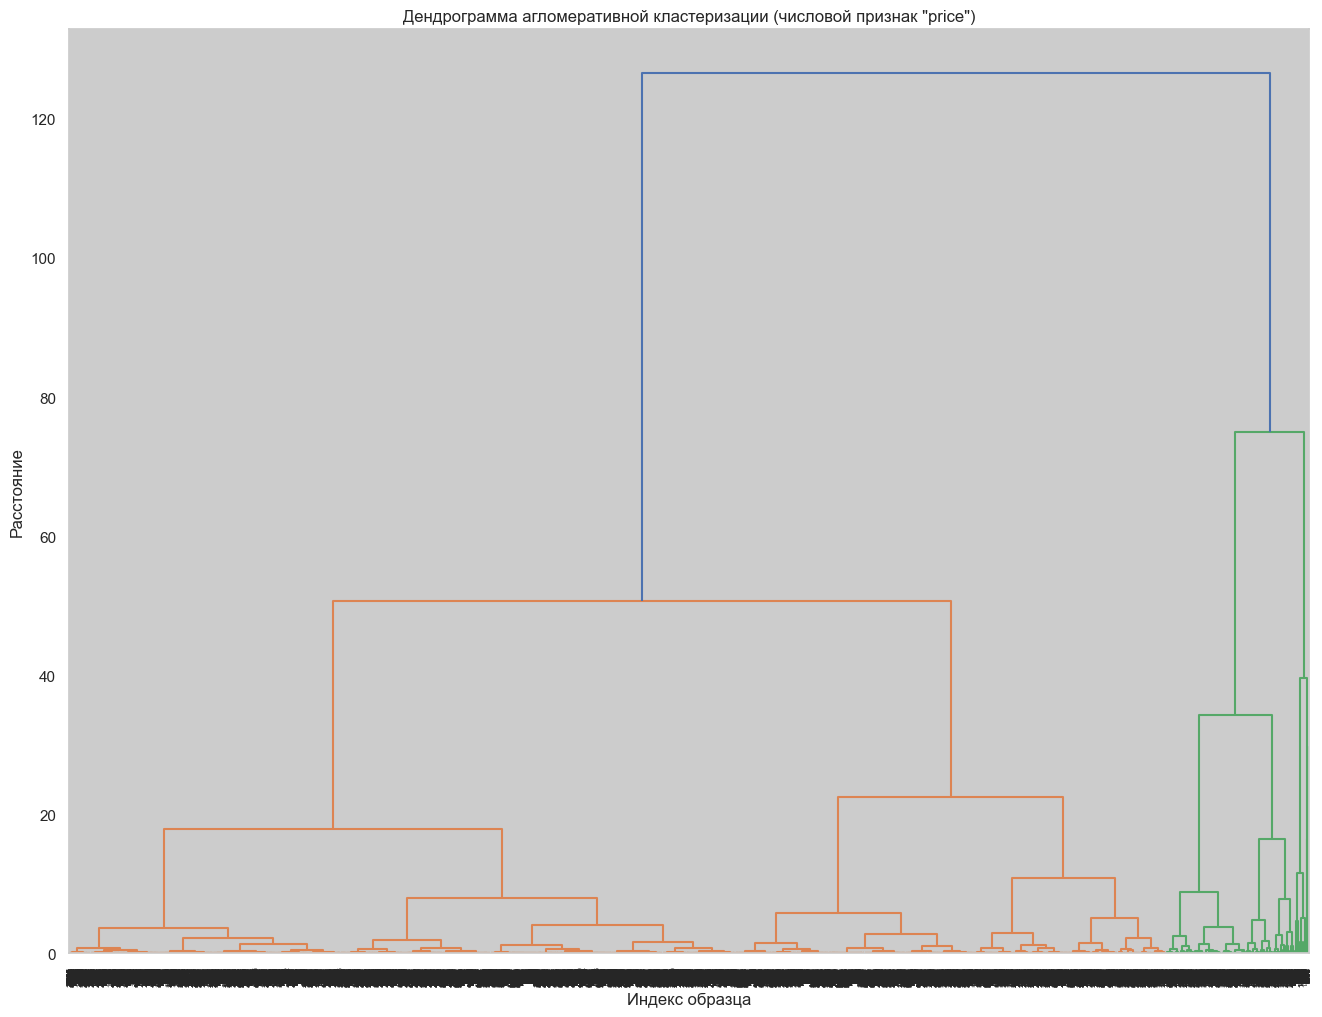

[1 1 1 ... 1 2 1]


In [ ]:
# Построение дендрограммы (только для числовых данных)
linkage_matrix = linkage(df_numerical_scaled, method='ward')

plt.figure(figsize=(16, 12))
dendrogram(linkage_matrix)
plt.title('Дендрограмма агломеративной кластеризации (числовой признак "price")')
plt.xlabel('Индекс образца')
plt.ylabel('Расстояние')
plt.show()

# Получение результатов кластеризации (только для числовых данных)
result = fcluster(linkage_matrix, t=100, criterion='distance') 
print(result)  # Вывод результатов кластеризации (номера кластеров для каждого образца)

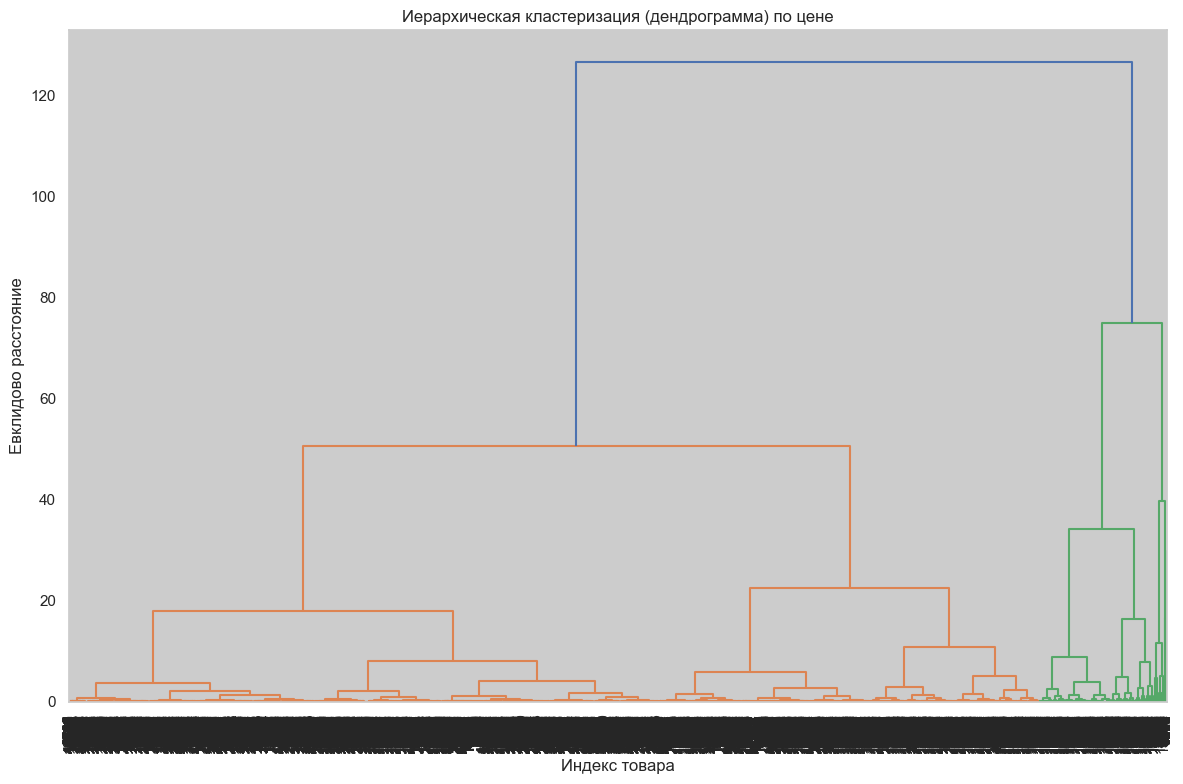

In [11]:
# Выбираем подмножество данных для кластеризации
features = df_encoded[['price']]

# Масштабирование числовых признаков
scaled_features = scaler.fit_transform(features)

# Построение дендрограммы
linkage_matrix = linkage(scaled_features, method='ward') 

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=df.index, leaf_rotation=90, leaf_font_size=10)
plt.title('Иерархическая кластеризация (дендрограмма) по цене')
plt.xlabel('Индекс товара')
plt.ylabel('Евклидово расстояние')
plt.tight_layout()
plt.show()

**Визуализация распределения кластеров**

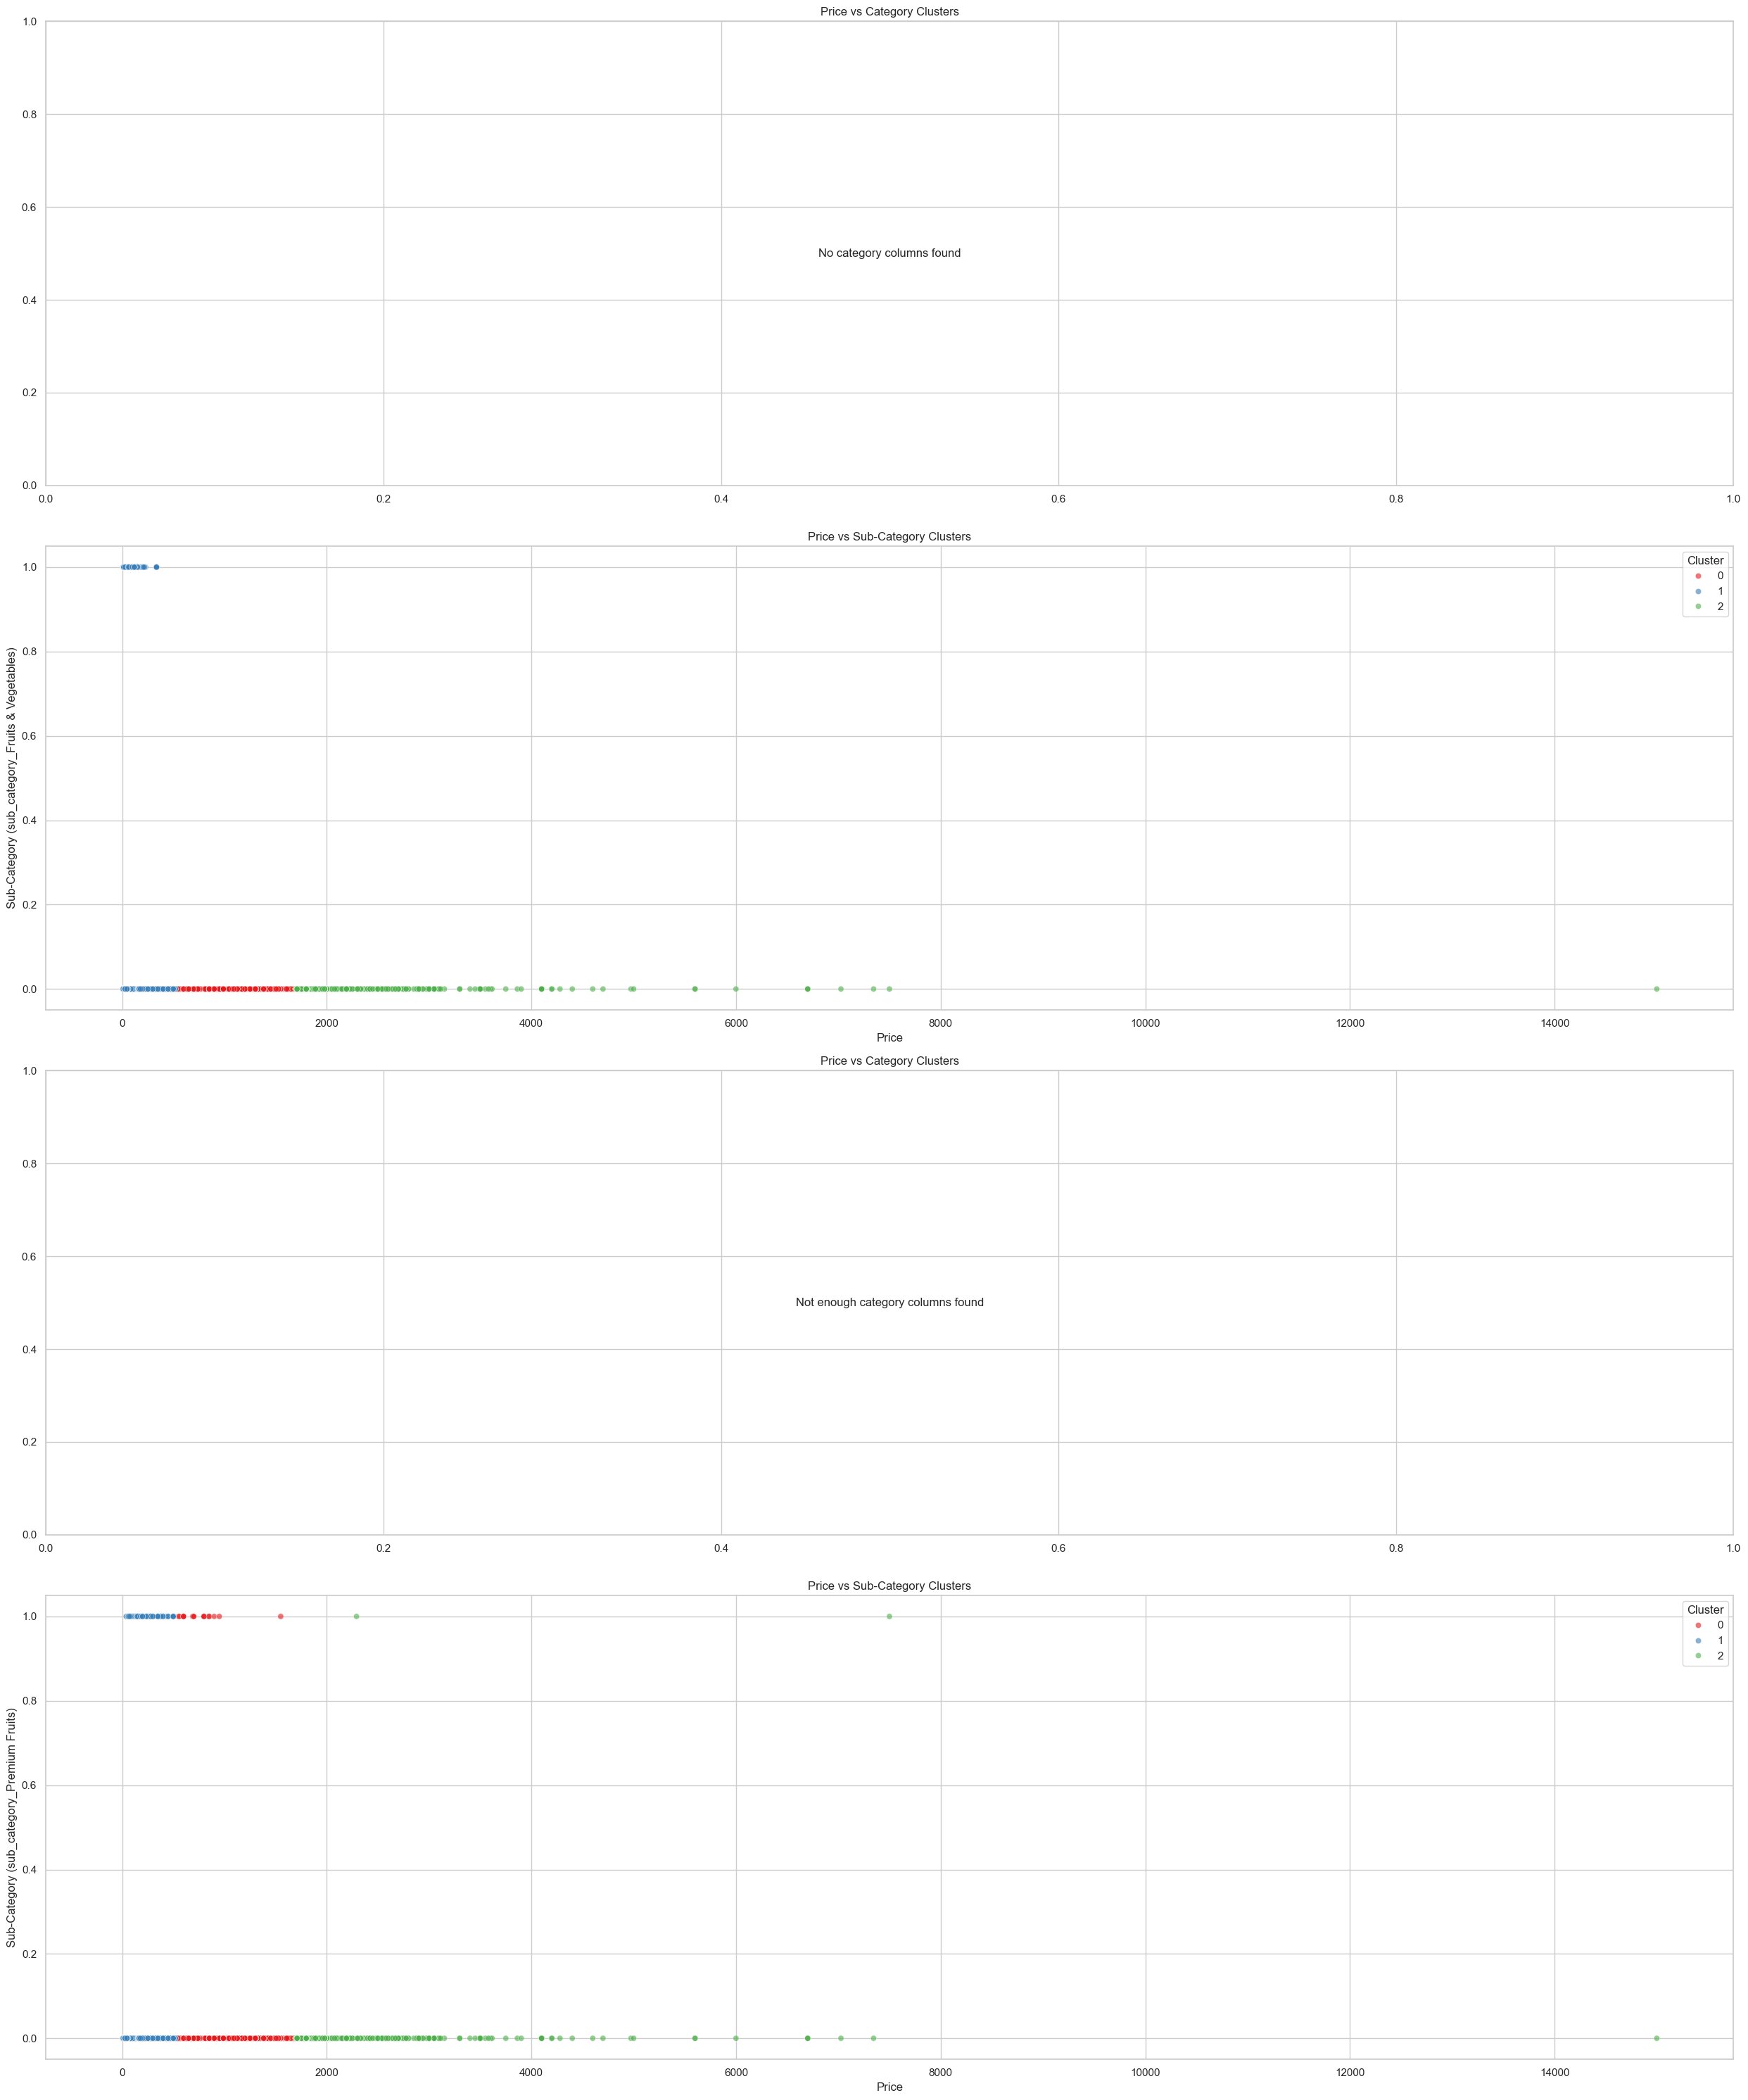

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Закодирование категориальных переменных
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Выбор подмножества данных для кластеризации
features = df_encoded[['price']]

# Масштабирование данных
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Кластеризация данных
kmeans = KMeans(n_clusters=3)
df_encoded['Cluster'] = kmeans.fit_predict(scaled_features)

# Визуализация кластеров
plt.figure(figsize=(25, 30))

# Парный график 1: Price vs Category
category_columns = [col for col in df_encoded.columns if col.startswith('category_')]
if category_columns:
    plt.subplot(4, 1, 1)
    sns.scatterplot(x=df_encoded['price'], y=df_encoded[category_columns[0]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('Price vs Category Clusters')
    plt.xlabel('Price')
    plt.ylabel(f'Category ({category_columns[0]})')
else:
    plt.subplot(4, 1, 1)
    plt.text(0.5, 0.5, 'No category columns found', ha='center', va='center', fontsize=12)
    plt.title('Price vs Category Clusters')

# Парный график 2: Price vs Sub-Category
sub_category_columns = [col for col in df_encoded.columns if col.startswith('sub_category_')]
if sub_category_columns:
    plt.subplot(4, 1, 2)
    sns.scatterplot(x=df_encoded['price'], y=df_encoded[sub_category_columns[0]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('Price vs Sub-Category Clusters')
    plt.xlabel('Price')
    plt.ylabel(f'Sub-Category ({sub_category_columns[0]})')
else:
    plt.subplot(4, 1, 2)
    plt.text(0.5, 0.5, 'No sub-category columns found', ha='center', va='center', fontsize=12)
    plt.title('Price vs Sub-Category Clusters')

# Парный график 3: Price vs Category (другая категория)
if len(category_columns) > 1:
    plt.subplot(4, 1, 3)
    sns.scatterplot(x=df_encoded['price'], y=df_encoded[category_columns[1]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('Price vs Category Clusters')
    plt.xlabel('Price')
    plt.ylabel(f'Category ({category_columns[1]})')
else:
    plt.subplot(4, 1, 3)
    plt.text(0.5, 0.5, 'Not enough category columns found', ha='center', va='center', fontsize=12)
    plt.title('Price vs Category Clusters')

# Парный график 4: Price vs Sub-Category (другая подкатегория)
if len(sub_category_columns) > 1:
    plt.subplot(4, 1, 4)
    sns.scatterplot(x=df_encoded['price'], y=df_encoded[sub_category_columns[1]], hue=df_encoded['Cluster'], palette='Set1', alpha=0.6)
    plt.title('Price vs Sub-Category Clusters')
    plt.xlabel('Price')
    plt.ylabel(f'Sub-Category ({sub_category_columns[1]})')
else:
    plt.subplot(4, 1, 4)
    plt.text(0.5, 0.5, 'Not enough sub-category columns found', ha='center', va='center', fontsize=12)
    plt.title('Price vs Sub-Category Clusters')

# Настройка графиков
plt.tight_layout()
plt.show()

## KMeans (неиерархическая кластеризация) для сравнения

Центры кластеров:
 [[ 194.76055021]
 [ 696.35470625]
 [1847.9773913 ]
 [5430.2962963 ]]


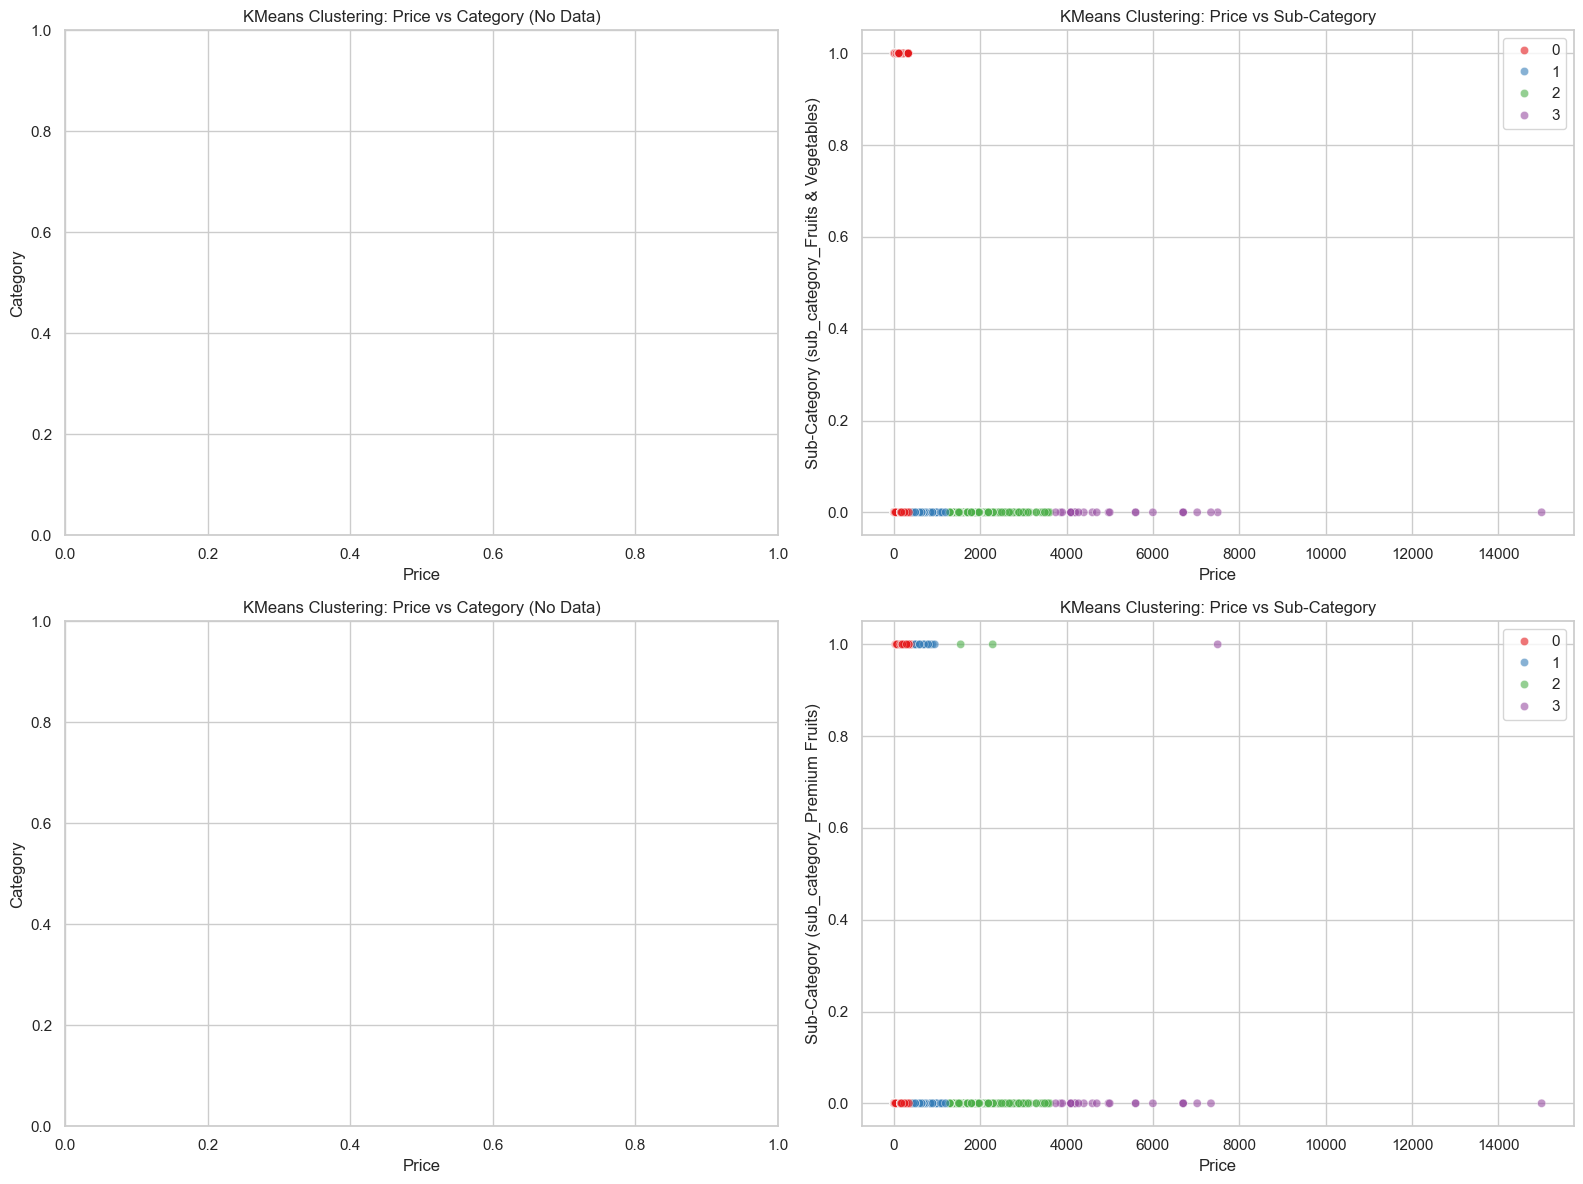

In [25]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv("..//static//csv//jio_mart_items.csv")
df = df.iloc[:15000]

# Удаление несущественных столбцов
columns_to_drop = ['href', 'items']
df_cleaned = df.drop(columns=columns_to_drop)

# Закодирование категориальных переменных
df_encoded = pd.get_dummies(df_cleaned, drop_first=True)

# Выбор подмножества данных для кластеризации
features_used = ['price']
data_to_scale = df_encoded[features_used]

# Масштабирование данных
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_to_scale)

# Кластеризация данных
random_state = 42
kmeans = KMeans(n_clusters=4, random_state=random_state)
labels = kmeans.fit_predict(data_scaled)
centers = kmeans.cluster_centers_

# Отображение центроидов
centers_original = scaler.inverse_transform(centers)  # Обратная стандартизация
print("Центры кластеров:\n", centers_original)

# Визуализация результатов кластеризации KMeans
plt.figure(figsize=(16, 12))

# Парный график 1: Price vs Category
plt.subplot(2, 2, 1)
category_columns = [col for col in df_encoded.columns if col.startswith('category_')]
if category_columns:
    sns.scatterplot(x=df_cleaned['price'], y=df_encoded[category_columns[0]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: Price vs Category')
    plt.xlabel('Price')
    plt.ylabel(f'Category ({category_columns[0]})')
else:
    plt.title('KMeans Clustering: Price vs Category (No Data)')
    plt.xlabel('Price')
    plt.ylabel('Category')

# Парный график 2: Price vs Sub-Category
plt.subplot(2, 2, 2)
sub_category_columns = [col for col in df_encoded.columns if col.startswith('sub_category_')]
if sub_category_columns:
    sns.scatterplot(x=df_cleaned['price'], y=df_encoded[sub_category_columns[0]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: Price vs Sub-Category')
    plt.xlabel('Price')
    plt.ylabel(f'Sub-Category ({sub_category_columns[0]})')
else:
    plt.title('KMeans Clustering: Price vs Sub-Category (No Data)')
    plt.xlabel('Price')
    plt.ylabel('Sub-Category')

# Парный график 3: Price vs Category (другая категория)
plt.subplot(2, 2, 3)
if len(category_columns) > 1:
    sns.scatterplot(x=df_cleaned['price'], y=df_encoded[category_columns[1]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: Price vs Category')
    plt.xlabel('Price')
    plt.ylabel(f'Category ({category_columns[1]})')
else:
    plt.title('KMeans Clustering: Price vs Category (No Data)')
    plt.xlabel('Price')
    plt.ylabel('Category')

# Парный график 4: Price vs Sub-Category (другая подкатегория)
plt.subplot(2, 2, 4)
if len(sub_category_columns) > 1:
    sns.scatterplot(x=df_cleaned['price'], y=df_encoded[sub_category_columns[1]], hue=labels, palette='Set1', alpha=0.6)
    plt.title('KMeans Clustering: Price vs Sub-Category')
    plt.xlabel('Price')
    plt.ylabel(f'Sub-Category ({sub_category_columns[1]})')
else:
    plt.title('KMeans Clustering: Price vs Sub-Category (No Data)')
    plt.xlabel('Price')
    plt.ylabel('Sub-Category')

# Настройка графиков
plt.tight_layout()
plt.show()

### PCA для визуализации сокращенной размерности

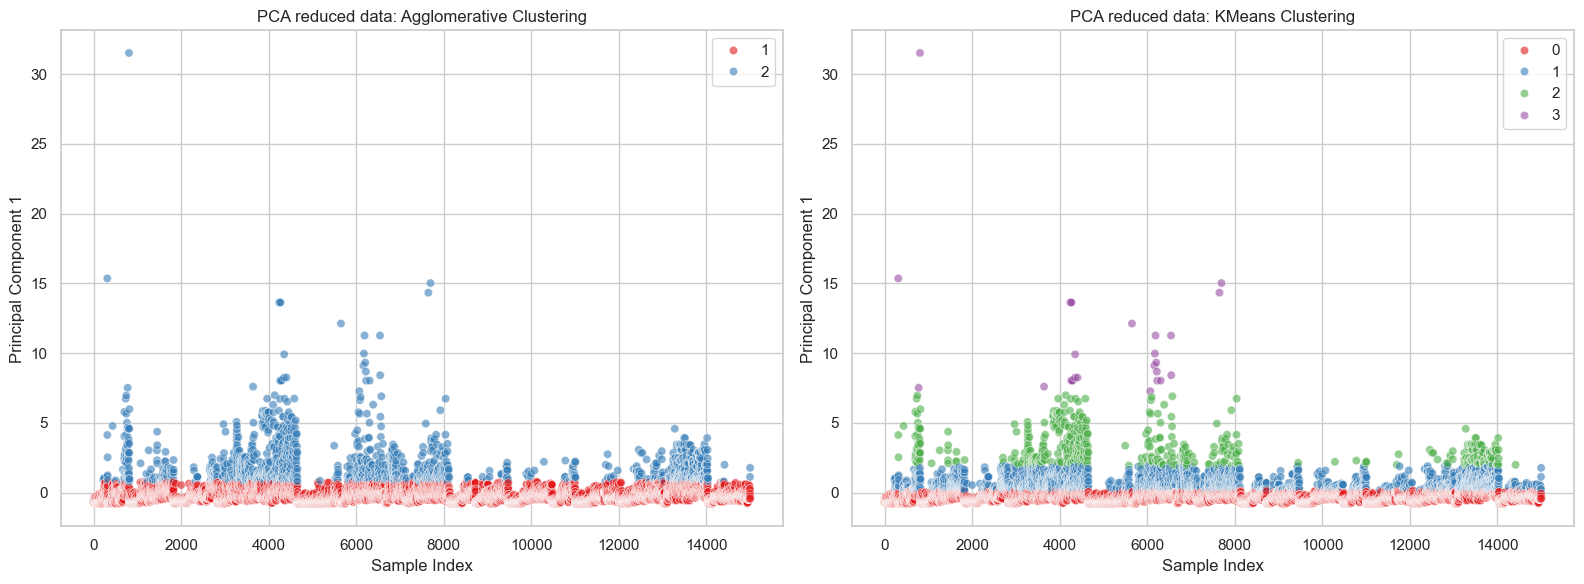

In [28]:
# Применение PCA ТОЛЬКО к числовым данным
pca = PCA(n_components=1)
reduced_data = pca.fit_transform(data_scaled)

# Визуализация сокращенных данных
plt.figure(figsize=(16, 6))

# График 1: PCA reduced data: Agglomerative Clustering
plt.subplot(1, 2, 1)
sns.scatterplot(x=range(len(reduced_data)), y=reduced_data[:, 0], hue=result, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: Agglomerative Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Principal Component 1')

# График 2: PCA reduced data: KMeans Clustering
plt.subplot(1, 2, 2)
sns.scatterplot(x=range(len(reduced_data)), y=reduced_data[:, 0], hue=labels, palette='Set1', alpha=0.6)
plt.title('PCA reduced data: KMeans Clustering')
plt.xlabel('Sample Index')
plt.ylabel('Principal Component 1')

plt.tight_layout()
plt.show()

### Анализ инерции для метода локтя (метод оценки суммы квадратов расстояний)

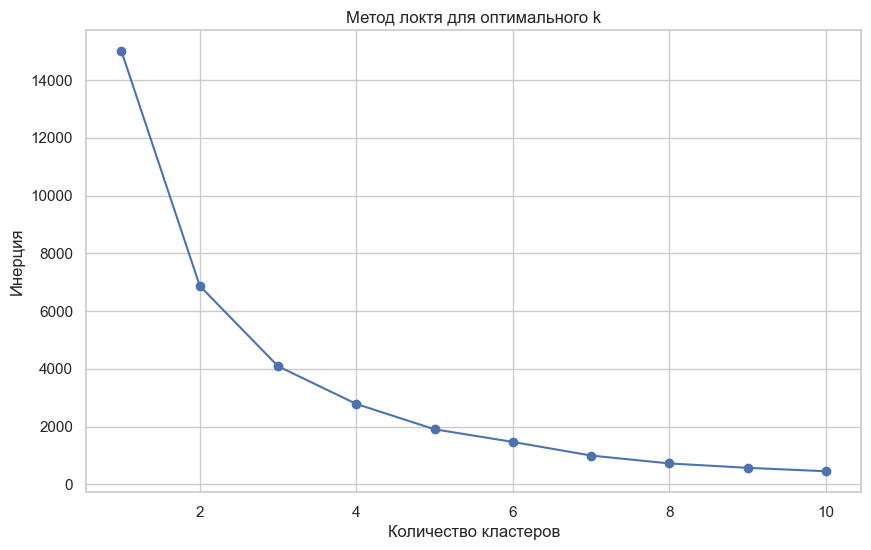

In [29]:
# Список для хранения инерций
inertias = []
clusters_range = range(1, 11)

# Вычисление инерции для каждого количества кластеров
for i in clusters_range:
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    kmeans.fit(data_scaled)
    inertias.append(kmeans.inertia_)

# Визуализация метода локтя
plt.figure(figsize=(10, 6))
plt.plot(clusters_range, inertias, marker='o')
plt.title('Метод локтя для оптимального k')
plt.xlabel('Количество кластеров')
plt.ylabel('Инерция')
plt.grid(True)
plt.show()

### Расчет коэффициентов силуэта

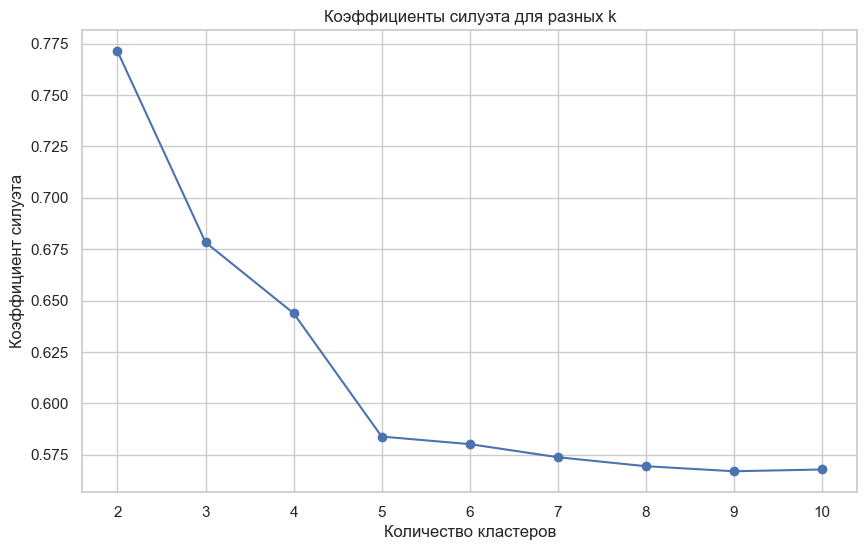

In [30]:
# Список для хранения коэффициентов силуэта
silhouette_scores = []

# Вычисление коэффициентов силуэта для каждого количества кластеров
for i in clusters_range[1:]:  
    kmeans = KMeans(n_clusters=i, random_state=random_state)
    labels = kmeans.fit_predict(data_scaled)
    score = silhouette_score(data_scaled, labels)
    silhouette_scores.append(score)

# Построение диаграммы значений силуэта
plt.figure(figsize=(10, 6))
plt.plot(clusters_range[1:], silhouette_scores, marker='o')
plt.title('Коэффициенты силуэта для разных k')
plt.xlabel('Количество кластеров')
plt.ylabel('Коэффициент силуэта')
plt.grid(True)
plt.show()

Средний коэффициент силуэта: 0.678


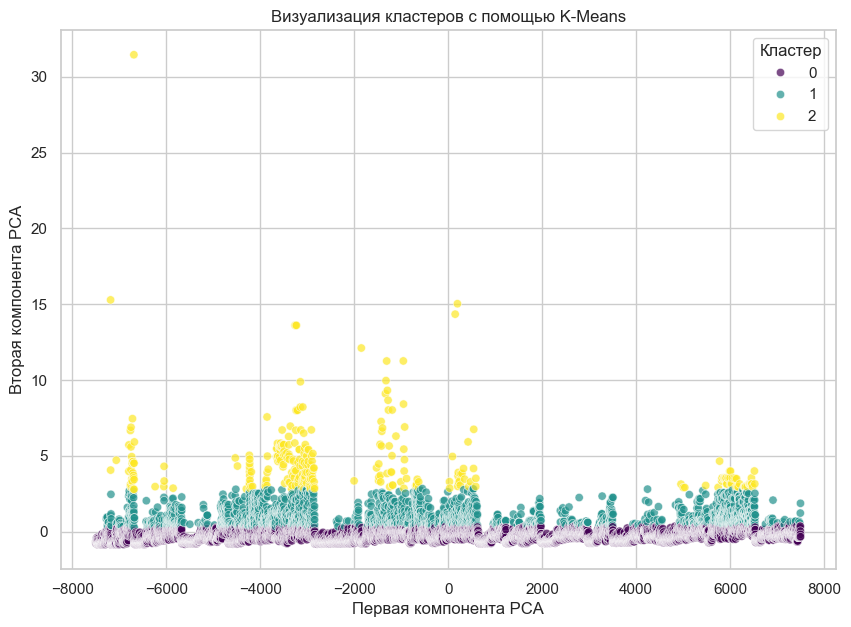

In [32]:
# Добавляем индекс строки как дополнительный признак
data_scaled_with_index = np.hstack((data_scaled, np.arange(data_scaled.shape[0]).reshape(-1, 1)))

# ========================
# Применение K-Means
# ========================
kmeans = KMeans(n_clusters=3, random_state=42)  
df_clusters = kmeans.fit_predict(data_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg = silhouette_score(data_scaled, df_clusters)
print(f'Средний коэффициент силуэта: {silhouette_avg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled_with_index)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=df_clusters, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью K-Means')
plt.xlabel('Первая компонента PCA')
plt.ylabel('Вторая компонента PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Средний коэффициент силуэта, равный 0.678, указывает на хорошую кластеризацию.  

Средний коэффициент силуэта (silhouette score) указывает на качество кластеризации, измеряя, насколько хорошо точки внутри одного кластера близки друг к другу по сравнению с точками из других кластеров. Значения коэффициента силуэта находятся в диапазоне от -1 до 1:

1: Указывает на идеально плотные и четко разделенные кластеры.  
0: Указывает на перекрытие кластеров или слабую структуру кластеризации.  
Отрицательные значения: Указывают, что точки в кластере расположены ближе к другому кластеру, чем к своему.

Средний коэффициент силуэта (агломеративная кластеризация): 0.724


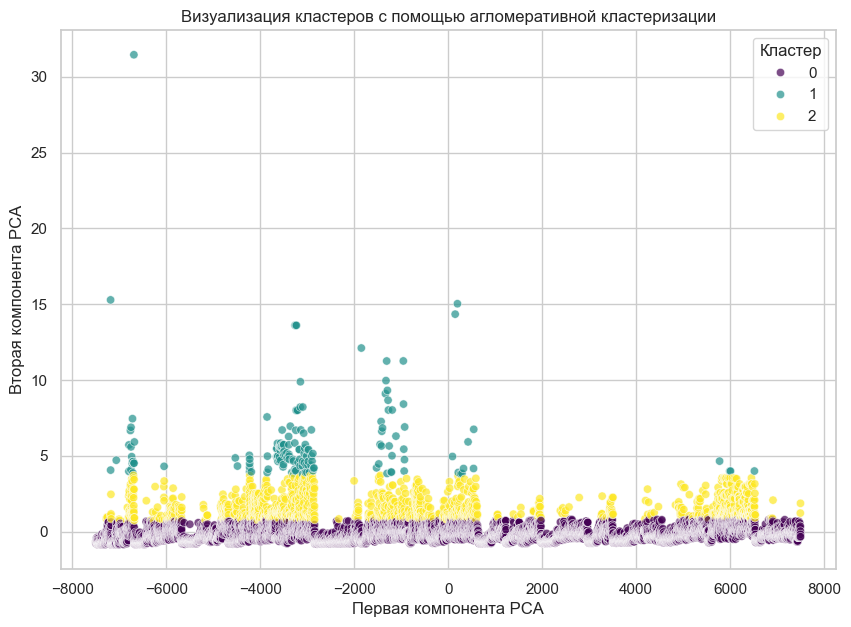

In [ ]:
# Добавляем индекс строки как дополнительный признак
data_scaled_with_index = np.hstack((data_scaled, np.arange(data_scaled.shape[0]).reshape(-1, 1)))

# ========================
# Агломеративная кластеризация
# ========================
agg_cluster = AgglomerativeClustering(n_clusters=3)  
labels_agg = agg_cluster.fit_predict(data_scaled)

# ========================
# Оценка качества кластеризации
# ========================
silhouette_avg_agg = silhouette_score(data_scaled, labels_agg)
print(f'Средний коэффициент силуэта (агломеративная кластеризация): {silhouette_avg_agg:.3f}')

# ========================
# Визуализация кластеров
# ========================
pca = PCA(n_components=2)
df_pca = pca.fit_transform(data_scaled_with_index)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca[:, 0], y=df_pca[:, 1], hue=labels_agg, palette='viridis', alpha=0.7)
plt.title('Визуализация кластеров с помощью агломеративной кластеризации')
plt.xlabel('Первая компонента PCA')
plt.ylabel('Вторая компонента PCA')
plt.legend(title='Кластер', loc='upper right')
plt.show()

Значение коэффициента силуэта лежит в диапазоне от -1 до 1. Ближе к 1: Хорошо сформированные, плотные кластеры, четко отделенные друг от друга.  

Ближе к 0: Кластеры пересекаются или слабо разделены, не имеют четких границ. Точки расположены одинаково близко как к своему кластеру, так и к соседним. 
Ближе к -1 (Отрицательные значения): Некоторые точки скорее относятся к другим кластерам, чем к текущему (ближе к центрам других кластеров). Очень плохая кластеризация.  
Ближе к 1: Все точки внутри каждого кластера плотно сгруппированы и значительно удалены от точек других кластеров. Свидетельствует о четкой и хорошо разделенной структуре данных. Единица говорит об идеальной кластеризации.

Средний коэффициент силуэта, равный 0.724, указывает на то, что кластеры имеют хорошее разделение и четкие границы. Точки внутри каждого кластера достаточно плотно сгруппированы и значительно удалены от точек других кластеров, что свидетельствует о четкой и хорошо разделенной структуре данных.